# Gaussian Fit for 2-Dimensional Spectra and Spatial Fitting | Version 0.1


In [3]:
cd /orange/adamginsburg/w51/vla/19A-254/derod/W

/orange/adamginsburg/w51/vla/19A-254/derod


# Work 1

<bound method DaskSpectralCubeMixin.max of DaskVaryingResolutionSpectralCube with shape=(100, 400, 400) and unit=Jy / beam and chunk size (10, 50, 50):
 n_x:    400  type_x: RA---SIN  unit_x: deg    range:   290.916051 deg:  290.917653 deg
 n_y:    400  type_y: DEC--SIN  unit_y: deg    range:    14.517394 deg:   14.518946 deg
 n_s:    100  type_s: FREQ      unit_s: Hz     range: 25710166408.363 Hz:25711713219.301 Hz> Cube Max)
Jy / beam Unit Flux


<ipython-input-7-bade57f2c246>:132: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 2)


Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude       x_mean      ...   y_stddev        theta       
    Jy / beam        deg        ...     deg                       
    --------- ----------------- ... ----------- ------------------
        500.0 290.9170756769094 ... 1.11111e-05 1.5707963267948966 Printed models.Gaussian2D
The errors are:
 [1.34440679e-02 7.25775081e-07 7.25735551e-07 7.25735551e-07
 7.25775081e-07 8.48082131e+02]
Parameter('amplitude', value=0.2058187079978814, unit=Jy / beam)
Parameter('x_mean', value=290.91707596149945, unit=deg)
Parameter('y_mean', value=14.518231599997083, unit=deg)
Parameter('x_stddev', value=7.862334378474588e-06, unit=deg, bounds=(1.1754943508222875e-38, None))
Parameter('y_stddev', value=7.862334378474588e-06, unit=deg, bounds=(1.1754943508222875e-38, None))
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean       ...       t

Save the gaussian fit (yes or no)? yes


File saved.


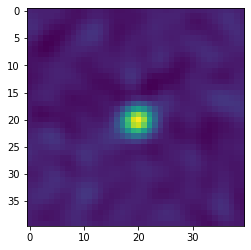

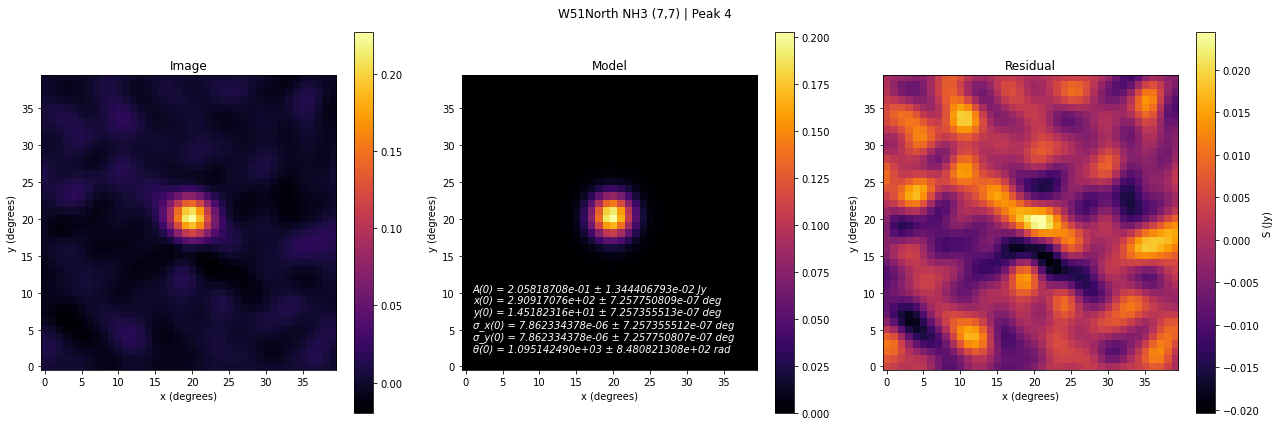

In [7]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

import pylab as pl

#Saving methods
field='W51North'
spw="28_4"
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/Gaussian2D_plots/'

def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit2D_V1.0.png')
            print('File saved.')
            
#Accessing Cube Data
cube = SpectralCube.read("/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_28_corrected31.image", format='casa_image')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5


# maser_channel = 579

x, y = 144, 215
size = 20

cube = cube[69,:,:]

#max_2d_cube = cube.max(axis=0)
cube_cutout = cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()

p_init_gauss2D = models.Gaussian2D(x_mean=290.9170756769094 * u.deg, y_mean=14.518231385948818 * u.deg, amplitude=500 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


# print("\n param_cov")

# print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)





print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North NH3 (7,7) | Peak 4")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 2)
plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
        " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
        " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
        style='italic',
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
        horizontalalignment='left')

plt.tight_layout()
saveplotfig_gaussianfit()

plt.show()

## June 7

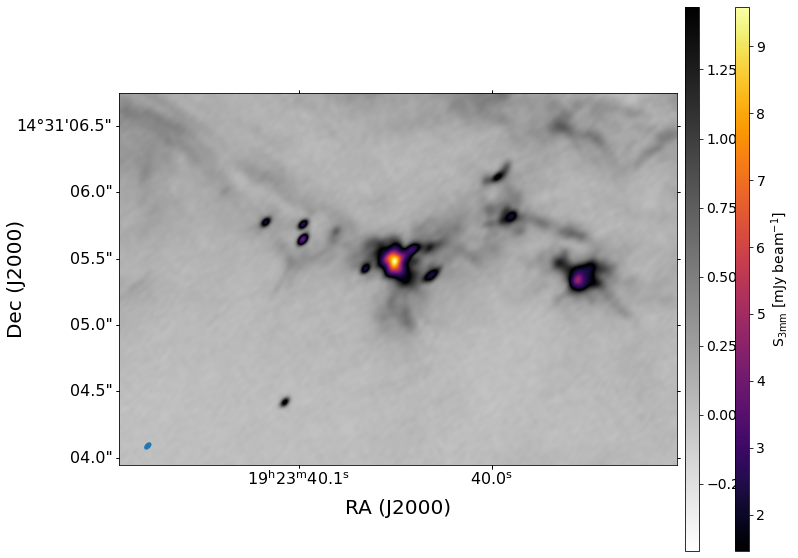

In [3]:
import sys
import numpy as np
sys.path.append('/orange/adamginsburg/ALMA_IMF/reduction/analysis/')
from quicklook_multicolorbar import quicklook
from spectral_cube import SpectralCube
import pylab as pl

fn = '/orange/adamginsburg/w51/2017.1.00293.S/may2021_imaging/w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0'
img = SpectralCube.read(fn, format='casa_image')
cen = img.shape[1]/2, img.shape[2]/2
fig = pl.figure(figsize=(10,10))
fig, ax = quicklook(img[:,cen[0]-150:cen[0]+250, cen[1]-400:cen[1]+200], fig=fig, inner_stretch='linear')

## June 12 & 13

### spw 38 (7,5)

In [ ]:
CASA <4>: tclean(vis='/orange/adamginsburg/w51/vla/19A-254/derod/19A-254_2019
     ...: _08_02_T15_20_05.733/19A-254.sb36820841.eb37001660.58697.1858300231
     ...: 5.ms',field='3',spw='38',imagename='W51North_spw_38_corrected6',cel
     ...: l='0.014arcsec',niter=100000000,specmode='cube',imsize=800,pblimit=
     ...: 0.1,interactive=False,robust=0,width=1,start=250,nchan=100,restfreq
     ...: ='20.80521481GHz',chanchunks=1,savemodel='modelcolumn',threshold='0
     ...: .062995Jy',outframe='LSRK',weighting='briggs')

Here, I will apply an updated 2D gaussian fit to the remainder of the masers I have, as well have a second look at the one dimensional spectrum.

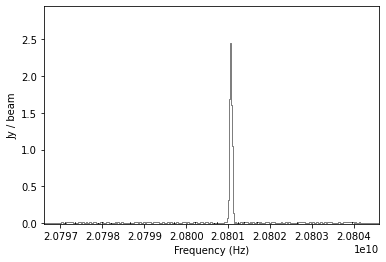

In [31]:
import pyspeckit
from spectral_cube import SpectralCube
from astropy import units as u

#Import data
cube = SpectralCube.read('/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_38_corrected5.image', format='casa_image')

import pylab as pl

# cube = cube.with_spectral_unit(u.km / u.s, velocity_convention='radio', rest_value= 20.80521481 * u.GHz)

#Pixel location (x,y)
y, x = 637, 358

sp = pyspeckit.Spectrum(xarr=cube.spectral_axis, data=cube[:, x, y])
sp.plotter(color='black')

<bound method DaskSpectralCubeMixin.max of DaskVaryingResolutionSpectralCube with shape=(100, 800, 800) and unit=Jy / beam and chunk size (5, 80, 80):
 n_x:    800  type_x: RA---SIN  unit_x: deg    range:   290.915247 deg:  290.918457 deg
 n_y:    800  type_y: DEC--SIN  unit_y: deg    range:    14.516617 deg:   14.519724 deg
 n_s:    100  type_s: FREQ      unit_s: Hz     range: 20800520118.895 Hz:20802066929.833 Hz> Cube Max)
Jy / beam Unit Flux
290.9158979310288 deg
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude       x_mean      ...   y_stddev        theta       
    Jy / beam        deg        ...     deg                       
    --------- ----------------- ... ----------- ------------------
        100.0 290.9158979310288 ... 1.11111e-05 1.5707963267948966 Printed models.Gaussian2D

 param_cov
{'nfev': 3, 'fvec': array([ 0.0343352 ,  0.02908005,  0.01380657, ..., -0.03007038,
       -0.00655059,  0.00884602]), 'fjac': array([[-9.5

Save the gaussian fit (yes or no)? no


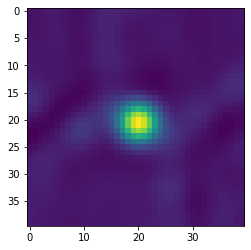

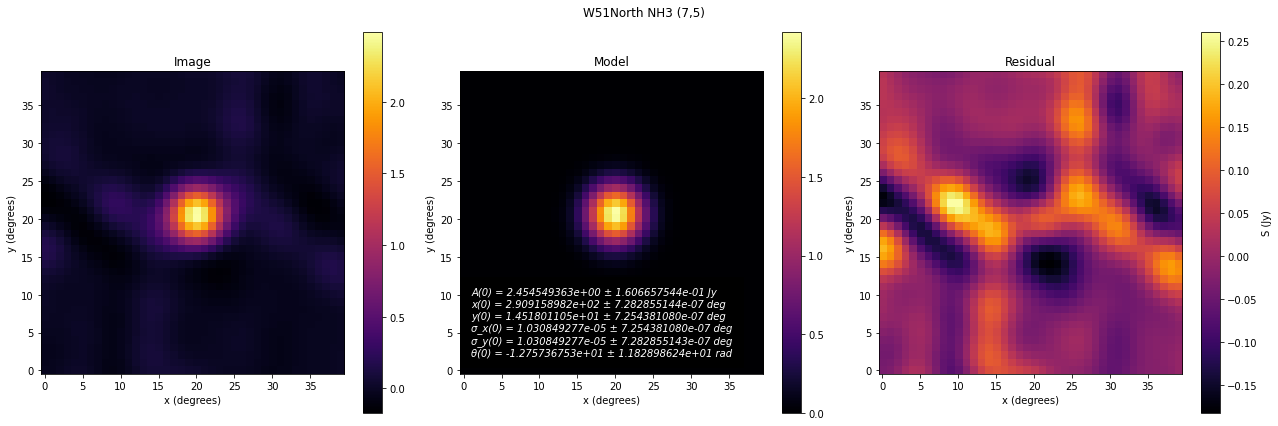

Parameter Error

2.454549363e+00 1.606657544e-01

2.909158982e+02 7.282855144e-07

1.451801105e+01 7.254381080e-07

1.030849277e-05 7.254381080e-07

1.030849277e-05 7.282855143e-07

-1.275736753e+01 1.182898624e+01



In [56]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

import pylab as pl

#Saving methods
field='W51North'
spw="38"
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/Gaussian2D_plots/'

def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit2D_V1.0.png')
            print('File saved.')
            
#Accessing Cube Data
cube = SpectralCube.read("/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_38_corrected6.image", format='casa_image')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5


# maser_channel = 579

x, y = 637, 358
size = 20

cube = cube[34,:,:]

#max_2d_cube = cube.max(axis=0)
cube_cutout = cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()
cord = cube.world[y,x]
print(cord[1])

p_init_gauss2D = models.Gaussian2D(x_mean=cord[1], y_mean=cord[0], amplitude=100 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


print("\n param_cov")

print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)




print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North NH3 (7,5)")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 2)
plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
        " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
        " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
        style='italic',
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
        horizontalalignment='left')

plt.tight_layout()
saveplotfig_gaussianfit()

plt.show()

print("Parameter" + ' ' + 'Error' +"\n")
print(amplitude + ' ' + amplitude_error +"\n")
print(x_mean + ' ' + x_mean_error +"\n")
print(y_mean + ' ' + y_mean_error +"\n")
print(x_stddev + ' ' + x_stddev_error +"\n")
print(y_stddev + ' ' + y_stddev_error +"\n")
print(theta + ' ' + theta_error +"\n")


## spw 53 (7,4)

In [ ]:
CASA <16>: tclean(vis='/orange/adamginsburg/w51/vla/19A-254/derod/19A-254_201
      ...: 9_08_02_T15_20_05.733/19A-254.sb36820841.eb37001660.58697.18583002
      ...: 315.ms',field='3',spw='53',imagename='W51North_spw_53_corrected2',
      ...: cell='0.014arcsec',niter=100000000,specmode='cube',imsize=800,pbli
      ...: mit=0.1,interactive=False,robust=0,width=1,start=200,nchan=200,res
      ...: tfreq='19.21887615GHz',chanchunks=1,savemodel='modelcolumn',thresh
      ...: old='0.020201Jy',outframe='LSRK',weighting='briggs')

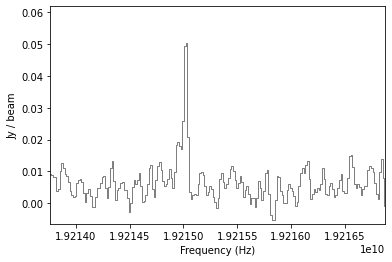

In [57]:
import pyspeckit
from spectral_cube import SpectralCube
from astropy import units as u

#Import data
cube = SpectralCube.read('/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_53_corrected2.image', format='casa_image')

import pylab as pl

# cube = cube.with_spectral_unit(u.km / u.s, velocity_convention='radio', rest_value= 20.80521481 * u.GHz)

#Pixel location (x,y)
y, x = 637, 358

sp = pyspeckit.Spectrum(xarr=cube.spectral_axis, data=cube[:, x, y])
sp.plotter(color='black')

Save the gaussian fit (yes or no)? no


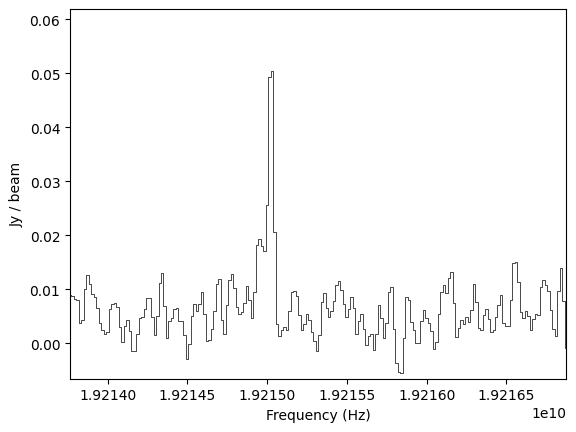

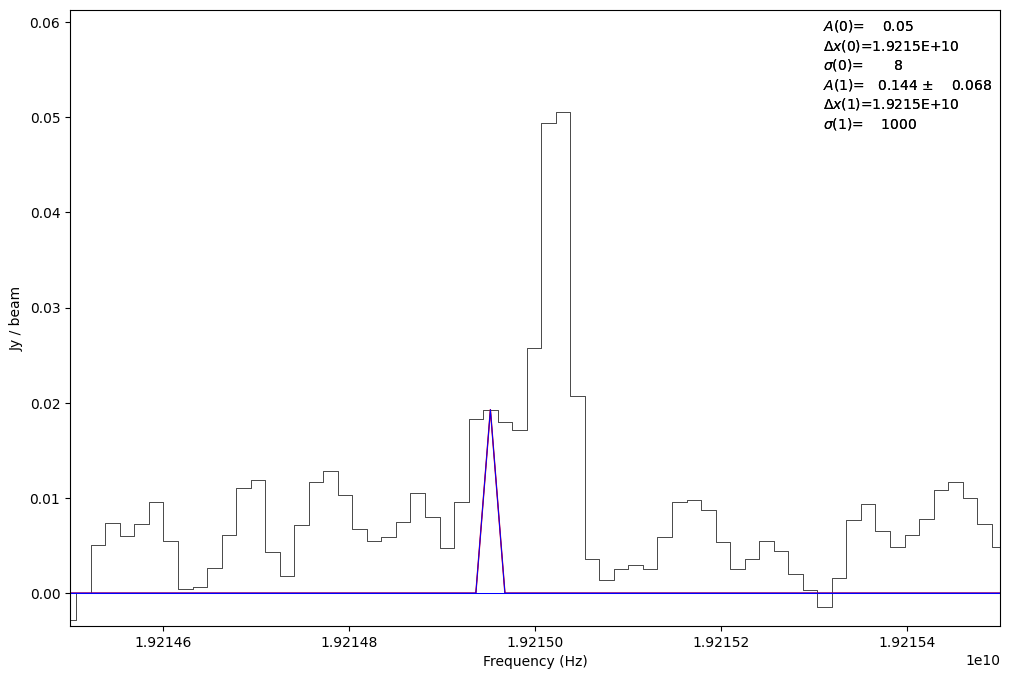

In [66]:
import pyspeckit
from spectral_cube import SpectralCube

#Import data
cube = SpectralCube.read('/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_53_corrected2.image', format='casa_image')

import pylab as pl
pl.style.use('default')

#Pixel location (x,y)
x, y = 637, 358

sp = pyspeckit.Spectrum(xarr=cube.spectral_axis, data=cube[:, y, x])
sp.plotter(color='black')

#Saving methods
field='W51North'
spw=53
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/gaussianplots/'

#Save gaussianfit
def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            sp.plotter.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit1D_V1.3.png')
            print('File saved.')
        
#Save residual        
def saveplotfig_residual():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the residual (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit1D_residual_V1.3.png')
            print('File saved.')
            
from astropy import units as u

#Plot the gassiuan fits in to each peak in the spectra
fig = pl.figure(figsize=(12,8))
sp.plotter(color='black', xmin=19.2145*u.GHz, xmax=19.2155*u.GHz, figure=fig)

#sp.specfit(guesses=[0.03, 19.21495e9, 0.00001e9, 0.05, 19.21503, 0.00001e9], linewidth=1.5)
sp.specfit(guesses=[0.05, 19.21503e9, 0.000008e6, 0.025, 19.21495e9, 0.000001e9], linewidth=1.5)
sp.specfit(guesses=[0.05, 19.21503e9, 0.000008e6, 0.025, 19.21495e9, 0.000001e9], linewidth=1.5)
# sp.specfit(guesses=[0.35, 21.0674e9, 0.00001e9], linewidth=1.5)
sp.specfit.plot_fit(lw=1.0, composite_lw=1.8, show_components=True)
saveplotfig_gaussianfit()

# #Plot the residuals of the gassiuan fits
# sp.specfit.plotresiduals(color='black', zeroline=True)
# pl.ylim(-0.05, 0.05)
# saveplotfig_residual()

<bound method DaskSpectralCubeMixin.max of DaskVaryingResolutionSpectralCube with shape=(200, 800, 800) and unit=Jy / beam and chunk size (10, 50, 50):
 n_x:    800  type_x: RA---SIN  unit_x: deg    range:   290.915247 deg:  290.918457 deg
 n_y:    800  type_y: DEC--SIN  unit_y: deg    range:    14.516617 deg:   14.519724 deg
 n_s:    200  type_s: FREQ      unit_s: Hz     range: 19213764555.630 Hz:19216873801.860 Hz> Cube Max)
Jy / beam Unit Flux
290.9158979310288 deg
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude       x_mean      ...   y_stddev        theta       
    Jy / beam        deg        ...     deg                       
    --------- ----------------- ... ----------- ------------------
        100.0 290.9158979310288 ... 1.11111e-05 1.5707963267948966 Printed models.Gaussian2D

 param_cov
{'nfev': 3, 'fvec': array([ 0.00624521,  0.00617801,  0.00516548, ..., -0.0021395 ,
       -0.00255522, -0.00295844]), 'fjac': array([[-2.

Save the gaussian fit (yes or no)? yes


File saved.


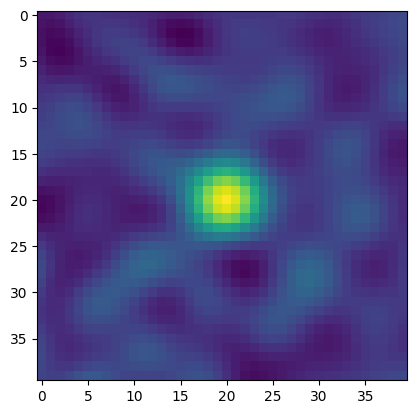

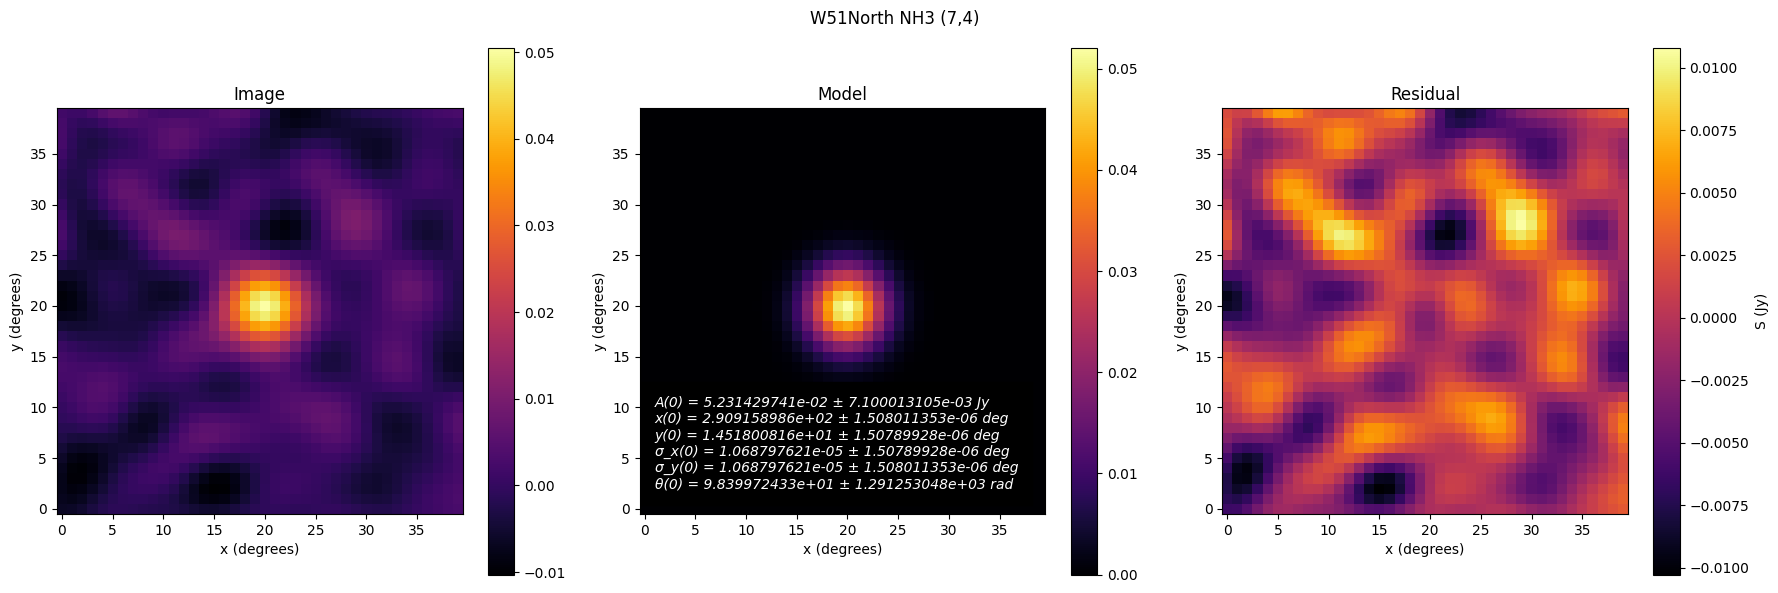

Parameter Error

5.231429741e-02 7.100013105e-03

2.909158986e+02 1.508011353e-06

1.451800816e+01 1.50789928e-06

1.068797621e-05 1.50789928e-06

1.068797621e-05 1.508011353e-06

9.839972433e+01 1.291253048e+03



In [68]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

import pylab as pl

#Saving methods
field='W51North'
spw="53"
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/Gaussian2D_plots/'

def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit2D_V1.0.png')
            print('File saved.')
            
#Accessing Cube Data
cube = SpectralCube.read("/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_53_corrected2.image", format='casa_image')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5


# maser_channel = 579

x, y = 637, 358
size = 20

cube = cube[81,:,:]

#max_2d_cube = cube.max(axis=0)
cube_cutout = cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()
cord = cube.world[y,x]
print(cord[1])

p_init_gauss2D = models.Gaussian2D(x_mean=cord[1], y_mean=cord[0], amplitude=100 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


print("\n param_cov")

print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)




print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North NH3 (7,4)")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 2)
plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
        " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
        " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
        style='italic',
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
        horizontalalignment='left')

plt.tight_layout()
saveplotfig_gaussianfit()

plt.show()

print("Parameter" + ' ' + 'Error' +"\n")
print(amplitude + ' ' + amplitude_error +"\n")
print(x_mean + ' ' + x_mean_error +"\n")
print(y_mean + ' ' + y_mean_error +"\n")
print(x_stddev + ' ' + x_stddev_error +"\n")
print(y_stddev + ' ' + y_stddev_error +"\n")
print(theta + ' ' + theta_error +"\n")

## spw 50 (6,2)

In [ ]:
CASA <7>: tclean(vis='/orange/adamginsburg/w51/vla/19A-254/derod/19A-254_2019
     ...: _08_02_T15_20_05.733/19A-254.sb36820841.eb37001660.58697.1858300231
     ...: 5.ms',field='3',spw='50',imagename='W51North_spw_50_corrected2',cel
     ...: l='0.014arcsec',niter=100000000,specmode='cube',imsize=800,pblimit=
     ...: 0.1,interactive=False,robust=0,width=1,start=200,nchan=100,restfreq
     ...: ='18.884645GHz',chanchunks=1,savemodel='modelcolumn',threshold='0.0
     ...: 18616Jy',outframe='LSRK',weighting='briggs')

Cube is a Stokes cube, returning spectral cube for I component


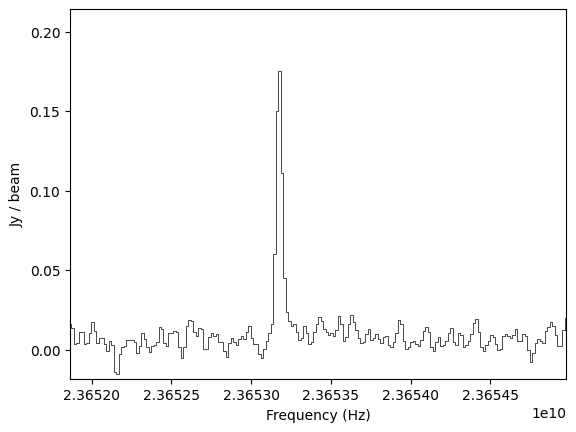

In [5]:
import pyspeckit
from spectral_cube import SpectralCube

#Import data
cube = SpectralCube.read('/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_8_corrected21.image', format='casa_image')

import pylab as pl
pl.style.use('default')

#Pixel location (x,y)
x, y = 637, 358

sp = pyspeckit.Spectrum(xarr=cube.spectral_axis, data=cube[:, y, x])
sp.plotter(color='black')


<bound method DaskSpectralCubeMixin.max of DaskVaryingResolutionSpectralCube with shape=(100, 800, 800) and unit=Jy / beam and chunk size (5, 80, 80):
 n_x:    800  type_x: RA---SIN  unit_x: deg    range:   290.915247 deg:  290.918457 deg
 n_y:    800  type_y: DEC--SIN  unit_y: deg    range:    14.516617 deg:   14.519724 deg
 n_s:    100  type_s: FREQ      unit_s: Hz     range: 18880047940.526 Hz:18881594751.465 Hz> Cube Max)
Jy / beam Unit Flux
290.915897931012 deg
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude      x_mean            y_mean       ...   y_stddev        theta       
    Jy / beam       deg               deg         ...     deg                       
    --------- ---------------- ------------------ ... ----------- ------------------
        100.0 290.915897931012 14.518012773030021 ... 1.11111e-05 1.5707963267948966 Printed models.Gaussian2D

 param_cov
{'nfev': 4, 'fvec': array([0.00068695, 0.00273931, 0.00492482, ..., 

Save the gaussian fit (yes or no)? yes


File saved.


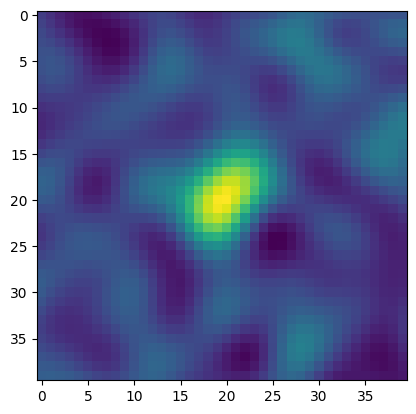

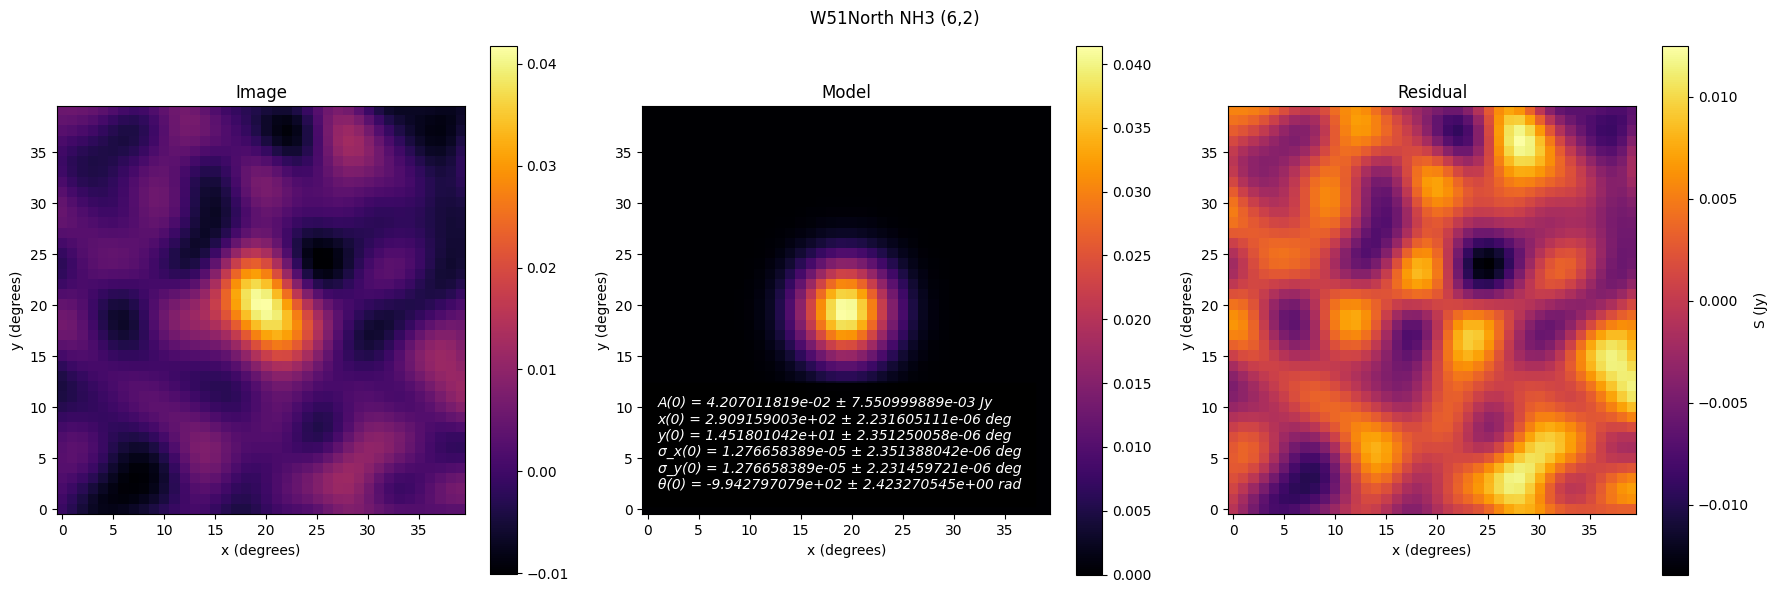

Parameter Error

4.207011819e-02 7.550999889e-03

2.909159003e+02 2.231605111e-06

1.451801042e+01 2.351250058e-06

1.276658389e-05 2.351388042e-06

1.276658389e-05 2.231459721e-06

-9.942797079e+02 2.423270545e+00



In [76]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

import pylab as pl

#Saving methods
field='W51North'
spw="50"
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/Gaussian2D_plots/'

def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit2D_V1.0.png')
            print('File saved.')
            
#Accessing Cube Data
cube = SpectralCube.read("/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_50_corrected2.image", format='casa_image')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5


# maser_channel = 579

x, y = 637, 359
size = 20

cube = cube[79,:,:]

#max_2d_cube = cube.max(axis=0)
cube_cutout = cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()
cord = cube.world[y,x]
print(cord[1])

p_init_gauss2D = models.Gaussian2D(x_mean=cord[1], y_mean=cord[0], amplitude=100 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


print("\n param_cov")

print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)




print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North NH3 (6,2)")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 2)
plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
        " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
        " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
        style='italic',
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
        horizontalalignment='left')

plt.tight_layout()
saveplotfig_gaussianfit()

plt.show()

print("Parameter" + ' ' + 'Error' +"\n")
print(amplitude + ' ' + amplitude_error +"\n")
print(x_mean + ' ' + x_mean_error +"\n")
print(y_mean + ' ' + y_mean_error +"\n")
print(x_stddev + ' ' + x_stddev_error +"\n")
print(y_stddev + ' ' + y_stddev_error +"\n")
print(theta + ' ' + theta_error +"\n")

<bound method DaskSpectralCubeMixin.max of DaskVaryingResolutionSpectralCube with shape=(150, 800, 800) and unit=Jy / beam and chunk size (10, 50, 50):
 n_x:    800  type_x: RA---SIN  unit_x: deg    range:   290.915247 deg:  290.918457 deg
 n_y:    800  type_y: DEC--SIN  unit_y: deg    range:    14.516617 deg:   14.519724 deg
 n_s:    150  type_s: FREQ      unit_s: Hz     range: 21280107055.770 Hz:21282435084.354 Hz> Cube Max)
Jy / beam Unit Flux
290.9159260511578 deg
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude       x_mean      ...   y_stddev        theta       
    Jy / beam        deg        ...     deg                       
    --------- ----------------- ... ----------- ------------------
        100.0 290.9159260511578 ... 1.11111e-05 1.5707963267948966 Printed models.Gaussian2D

 param_cov
{'nfev': 3, 'fvec': array([ 0.00497363, -0.00227628, -0.00693891, ..., -0.00801601,
       -0.00767528, -0.00816767]), 'fjac': array([[-3.

Save the gaussian fit (yes or no)? yes


File saved.


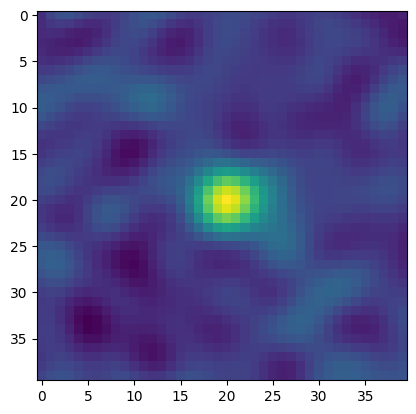

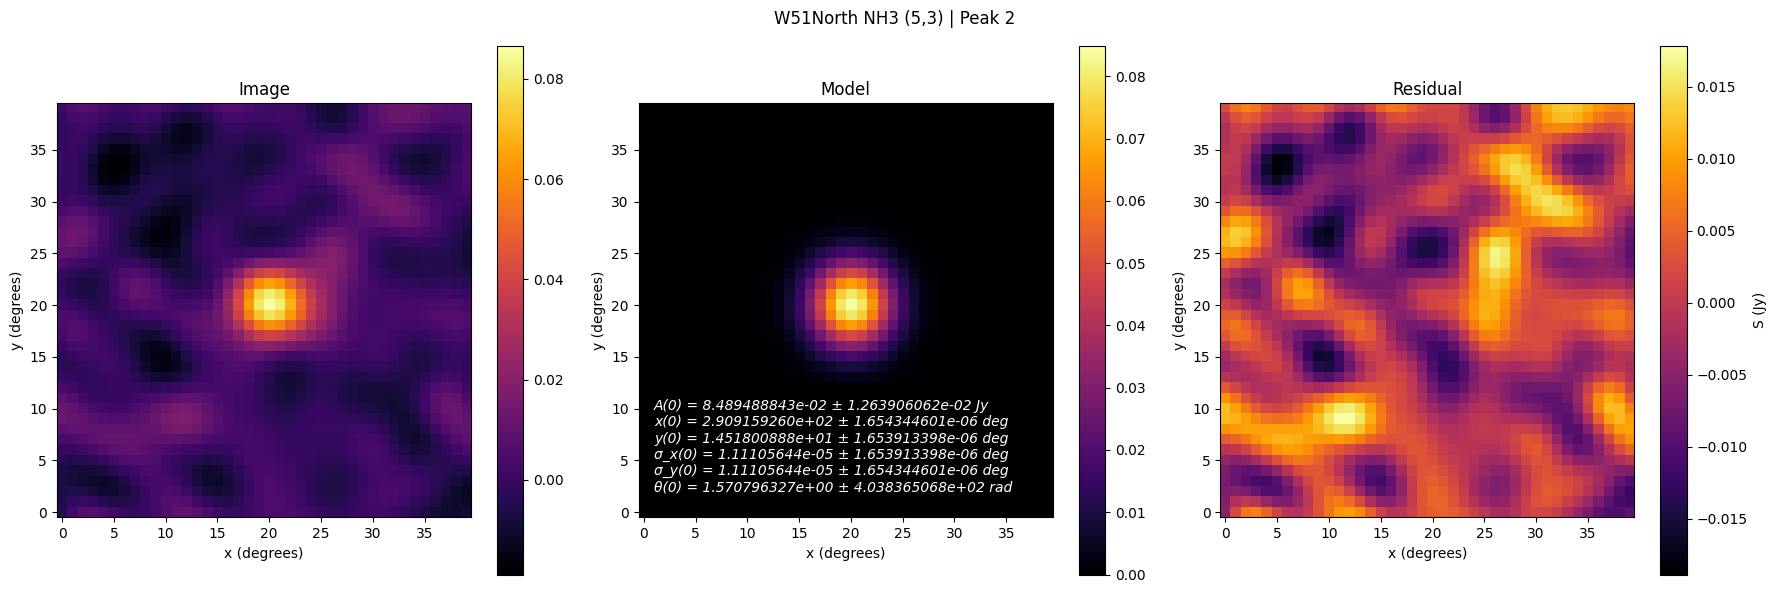

Parameter Error

8.489488843e-02 1.263906062e-02

2.909159260e+02 1.654344601e-06

1.451800888e+01 1.653913398e-06

1.11105644e-05 1.653913398e-06

1.11105644e-05 1.654344601e-06

1.570796327e+00 4.038365068e+02



In [75]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

import pylab as pl

#Saving methods
field='W51North'
spw="44"
directory1 = '/orange/adamginsburg/w51/vla/19A-2544
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit2D_V1.0.png')
            print('File saved.')
            
#Accessing Cube Data
cube = SpectralCube.read("/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_44_corrected2.image", format='casa_image')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5


# maser_channel = 579

x, y = 630, 358
size = 20

cube = cube[83,:,:]

#max_2d_cube = cube.max(axis=0)
cube_cutout = cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()
cord = cube.world[y,x]
print(cord[1])

p_init_gauss2D = models.Gaussian2D(x_mean=cord[1], y_mean=cord[0], amplitude=100 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


print("\n param_cov")

print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)




print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North NH3 (5,3) | Peak 2")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 2)
plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
        " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
        " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
        style='italic',
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
        horizontalalignment='left')

plt.tight_layout()
saveplotfig_gaussianfit()

plt.show()

print("Parameter" + ' ' + 'Error' +"\n")
print(amplitude + ' ' + amplitude_error +"\n")
print(x_mean + ' ' + x_mean_error +"\n")
print(y_mean + ' ' + y_mean_error +"\n")
print(x_stddev + ' ' + x_stddev_error +"\n")
print(y_stddev + ' ' + y_stddev_error +"\n")
print(theta + ' ' + theta_error +"\n")

## spw 56 (6,3)

<bound method DaskSpectralCubeMixin.max of DaskVaryingResolutionSpectralCube with shape=(50, 800, 800) and unit=Jy / beam and chunk size (5, 80, 80):
 n_x:    800  type_x: RA---SIN  unit_x: deg    range:   290.915247 deg:  290.918457 deg
 n_y:    800  type_y: DEC--SIN  unit_y: deg    range:    14.516617 deg:   14.519724 deg
 n_s:     50  type_s: FREQ      unit_s: Hz     range: 19753532550.103 Hz:19754298143.395 Hz> Cube Max)
Jy / beam Unit Flux
290.9158939139011 deg
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude       x_mean      ...   y_stddev        theta       
    Jy / beam        deg        ...     deg                       
    --------- ----------------- ... ----------- ------------------
        100.0 290.9158939139011 ... 1.11111e-05 1.5707963267948966 Printed models.Gaussian2D

 param_cov
{'nfev': 3, 'fvec': array([0.00105891, 0.00436065, 0.00790169, ..., 0.00684408, 0.00604963,
       0.00461128]), 'fjac': array([[-3.14268804

Save the gaussian fit (yes or no)? yes


File saved.


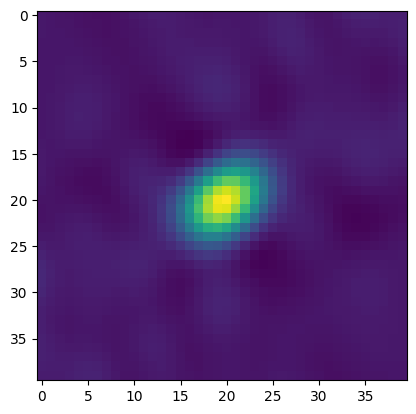

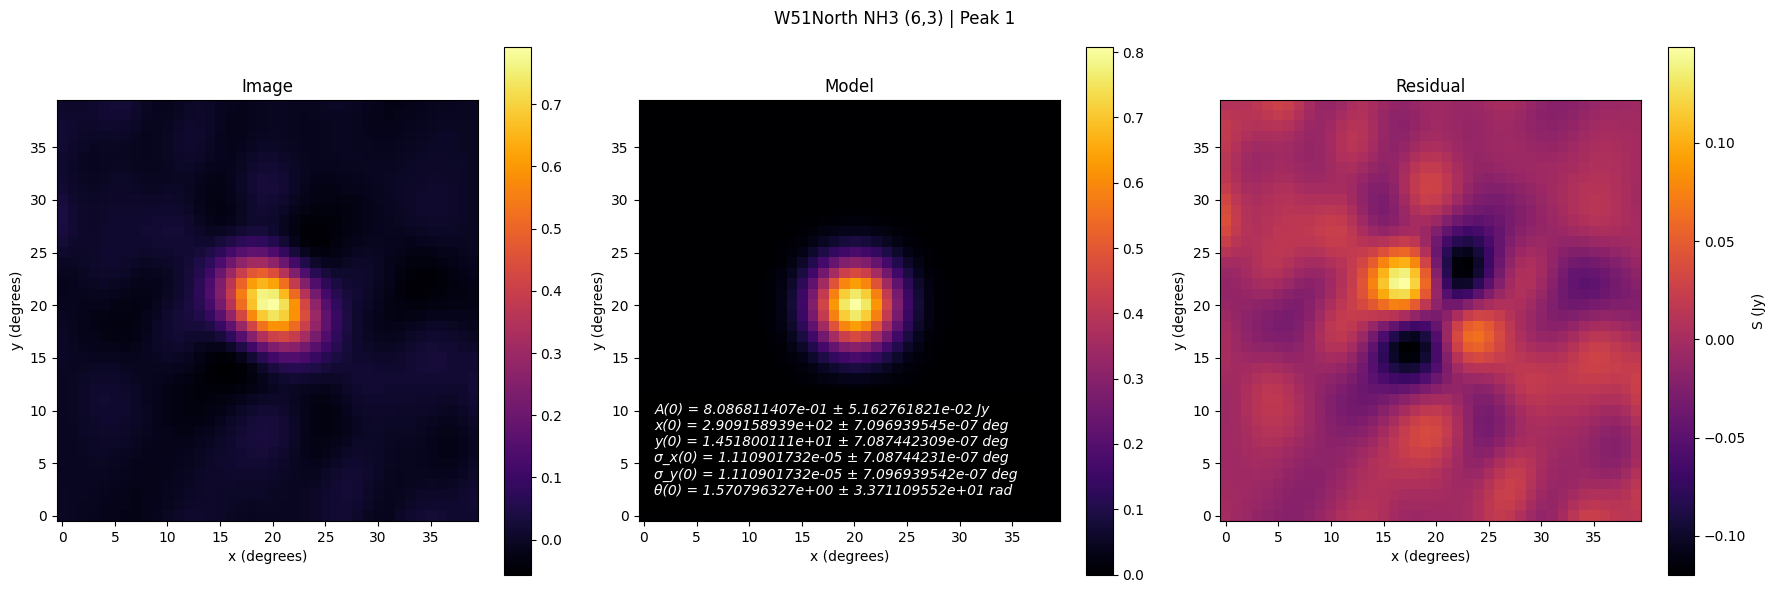

Parameter Error

8.086811407e-01 5.162761821e-02

2.909158939e+02 7.096939545e-07

1.451800111e+01 7.087442309e-07

1.110901732e-05 7.08744231e-07

1.110901732e-05 7.096939542e-07

1.570796327e+00 3.371109552e+01



In [83]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

import pylab as pl

#Saving methods
field='W51North'
spw="56"
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/Gaussian2D_plots/'

def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit2D_V1.0.png')
            print('File saved.')
            
#Accessing Cube Data
cube = SpectralCube.read("/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_56_corrected2.image", format='casa_image')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5


# maser_channel = 579

x, y = 638, 356
size = 20

cube = cube[21,:,:]

#max_2d_cube = cube.max(axis=0)
cube_cutout = cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()
cord = cube.world[y,x]
print(cord[1])

p_init_gauss2D = models.Gaussian2D(x_mean=cord[1], y_mean=cord[0], amplitude=100 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


print("\n param_cov")

print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)




print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North NH3 (6,3) | Peak 1")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 2)
plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
        " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
        " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
        style='italic',
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
        horizontalalignment='left')

plt.tight_layout()
saveplotfig_gaussianfit()

plt.show()

print("Parameter" + ' ' + 'Error' +"\n")
print(amplitude + ' ' + amplitude_error +"\n")
print(x_mean + ' ' + x_mean_error +"\n")
print(y_mean + ' ' + y_mean_error +"\n")
print(x_stddev + ' ' + x_stddev_error +"\n")
print(y_stddev + ' ' + y_stddev_error +"\n")
print(theta + ' ' + theta_error +"\n")

<bound method DaskSpectralCubeMixin.max of DaskVaryingResolutionSpectralCube with shape=(50, 800, 800) and unit=Jy / beam and chunk size (5, 80, 80):
 n_x:    800  type_x: RA---SIN  unit_x: deg    range:   290.915247 deg:  290.918457 deg
 n_y:    800  type_y: DEC--SIN  unit_y: deg    range:    14.516617 deg:   14.519724 deg
 n_s:     50  type_s: FREQ      unit_s: Hz     range: 19753532550.103 Hz:19754298143.395 Hz> Cube Max)
Jy / beam Unit Flux
290.9159260511578 deg
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude       x_mean      ...   y_stddev        theta       
    Jy / beam        deg        ...     deg                       
    --------- ----------------- ... ----------- ------------------
        100.0 290.9159260511578 ... 1.11111e-05 1.5707963267948966 Printed models.Gaussian2D

 param_cov
{'nfev': 4, 'fvec': array([-0.00051555, -0.00227459, -0.00361296, ...,  0.00582818,
        0.00679716,  0.00568155]), 'fjac': array([[-5.70

Save the gaussian fit (yes or no)? yes


File saved.


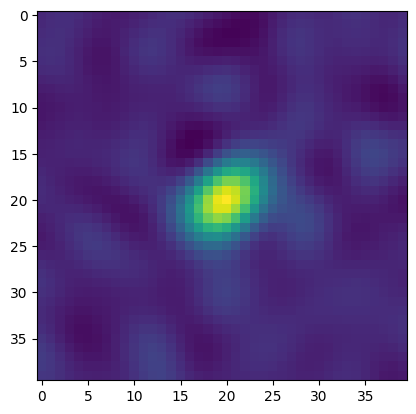

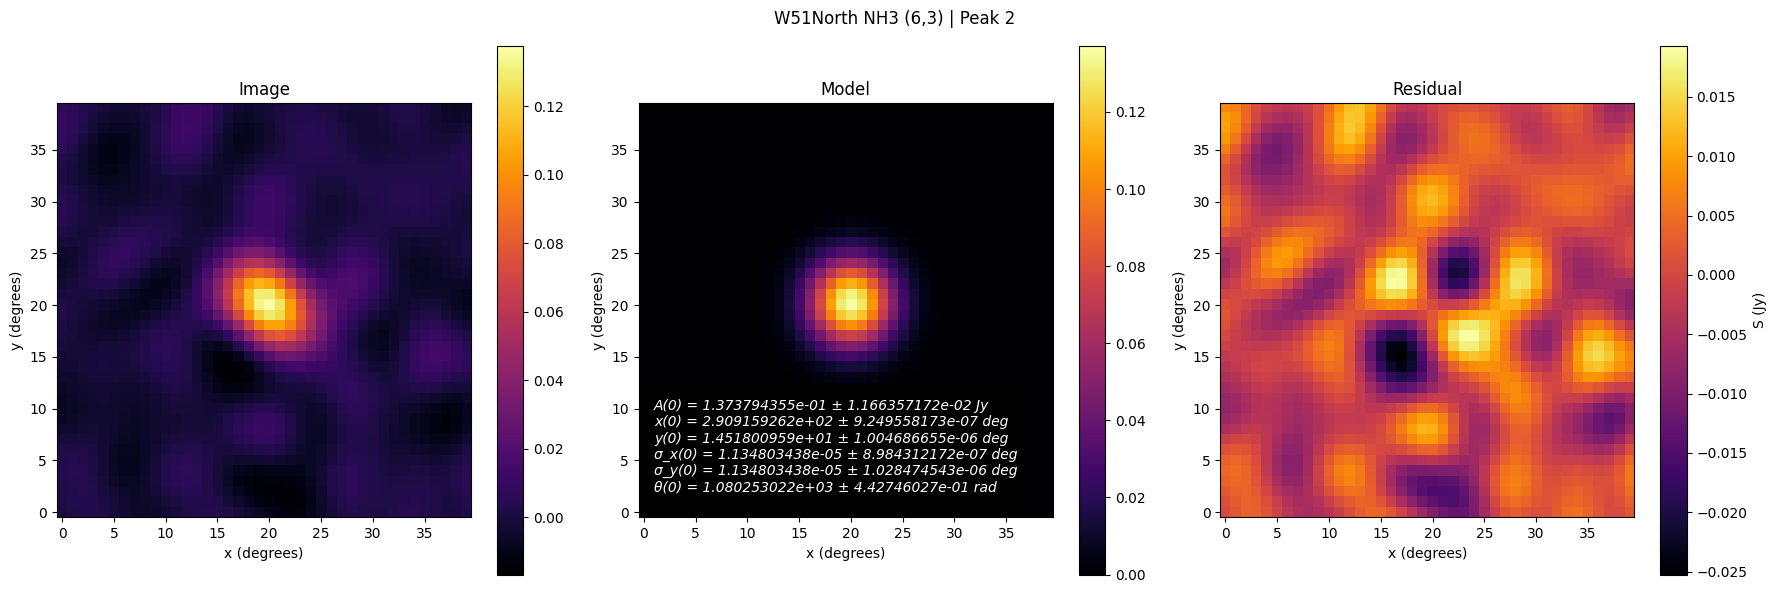

Parameter Error

1.373794355e-01 1.166357172e-02

2.909159262e+02 9.249558173e-07

1.451800959e+01 1.004686655e-06

1.134803438e-05 8.984312172e-07

1.134803438e-05 1.028474543e-06

1.080253022e+03 4.42746027e-01



In [85]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

import pylab as pl

#Saving methods
field='W51North'
spw="56_2"
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/Gaussian2D_plots/'

def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit2D_V1.0.png')
            print('File saved.')
            
#Accessing Cube Data
cube = SpectralCube.read("/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_56_corrected2.image", format='casa_image')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5


# maser_channel = 579

x, y = 630, 358
size = 20

cube = cube[29,:,:]

#max_2d_cube = cube.max(axis=0)
cube_cutout = cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()
cord = cube.world[y,x]
print(cord[1])

p_init_gauss2D = models.Gaussian2D(x_mean=cord[1], y_mean=cord[0], amplitude=100 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


print("\n param_cov")

print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)




print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North NH3 (6,3) | Peak 2")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 2)
plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
        " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
        " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
        style='italic',
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
        horizontalalignment='left')

plt.tight_layout()
saveplotfig_gaussianfit()

plt.show()

print("Parameter" + ' ' + 'Error' +"\n")
print(amplitude + ' ' + amplitude_error +"\n")
print(x_mean + ' ' + x_mean_error +"\n")
print(y_mean + ' ' + y_mean_error +"\n")
print(x_stddev + ' ' + x_stddev_error +"\n")
print(y_stddev + ' ' + y_stddev_error +"\n")
print(theta + ' ' + theta_error +"\n")

<bound method DaskSpectralCubeMixin.max of DaskVaryingResolutionSpectralCube with shape=(100, 800, 800) and unit=Jy / beam and chunk size (5, 80, 80):
 n_x:    800  type_x: RA---SIN  unit_x: deg    range:   290.915247 deg:  290.918457 deg
 n_y:    800  type_y: DEC--SIN  unit_y: deg    range:    14.516617 deg:   14.519724 deg
 n_s:    100  type_s: FREQ      unit_s: Hz     range: 18803872126.353 Hz:18805418937.292 Hz> Cube Max)
Jy / beam Unit Flux
290.9158979310288 deg
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude       x_mean      ...   y_stddev        theta       
    Jy / beam        deg        ...     deg                       
    --------- ----------------- ... ----------- ------------------
        100.0 290.9158979310288 ... 1.11111e-05 1.5707963267948966 Printed models.Gaussian2D

 param_cov
{'nfev': 3, 'fvec': array([-0.00282735, -0.00087163,  0.00129916, ...,  0.00183784,
        0.00171799,  0.00140396]), 'fjac': array([[-4.4

<ipython-input-1-a786eb17cd4d>:133: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 2)


Save the gaussian fit (yes or no)? yes


File saved.


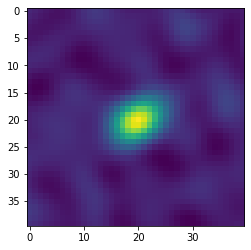

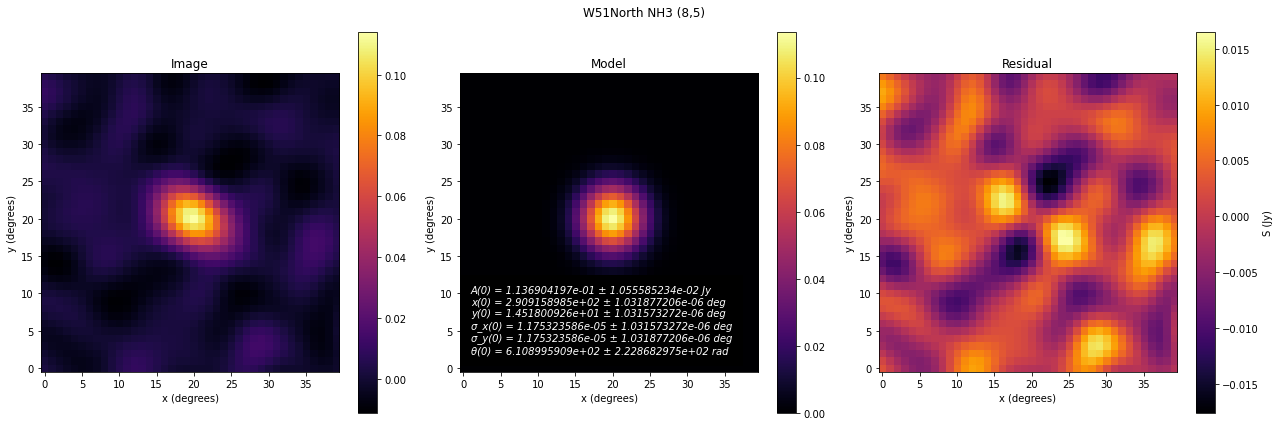

Parameter Error

1.136904197e-01 1.055585234e-02

2.909158985e+02 1.031877206e-06

1.451800926e+01 1.031573272e-06

1.175323586e-05 1.031573272e-06

1.175323586e-05 1.031877206e-06

6.108995909e+02 2.228682975e+02



In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

import pylab as pl

#Saving methods
field='W51North'
spw="48"
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/Gaussian2D_plots/'

def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit2D_V1.0.png')
            print('File saved.')
            
#Accessing Cube Data
cube = SpectralCube.read("/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_48_corrected2.image", format='casa_image')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5


# maser_channel = 579

x, y = 637, 358
size = 20

cube = cube[79,:,:]

#max_2d_cube = cube.max(axis=0)
cube_cutout = cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()
cord = cube.world[y,x]
print(cord[1])

p_init_gauss2D = models.Gaussian2D(x_mean=cord[1], y_mean=cord[0], amplitude=100 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


print("\n param_cov")

print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)




print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North NH3 (8,5)")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 2)
plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
        " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
        " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
        style='italic',
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
        horizontalalignment='left')

plt.tight_layout()
saveplotfig_gaussianfit()

plt.show()

print("Parameter" + ' ' + 'Error' +"\n")
print(amplitude + ' ' + amplitude_error +"\n")
print(x_mean + ' ' + x_mean_error +"\n")
print(y_mean + ' ' + y_mean_error +"\n")
print(x_stddev + ' ' + x_stddev_error +"\n")
print(y_stddev + ' ' + y_stddev_error +"\n")
print(theta + ' ' + theta_error +"\n")

<bound method DaskSpectralCubeMixin.max of DaskVaryingResolutionSpectralCube with shape=(200, 800, 800) and unit=Jy / beam and chunk size (10, 50, 50):
 n_x:    800  type_x: RA---SIN  unit_x: deg    range:   290.915247 deg:  290.918457 deg
 n_y:    800  type_y: DEC--SIN  unit_y: deg    range:    14.516617 deg:   14.519724 deg
 n_s:    200  type_s: FREQ      unit_s: Hz     range: 23651865317.468 Hz:23654974563.698 Hz> Cube Max)
Jy / beam Unit Flux
INFO: Auto-setting vmin to -4.007e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.711e-01 [aplpy.core]
290.9158979310288 deg
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude       x_mean      ...   y_stddev        theta       
    Jy / beam        deg        ...     deg                       
    --------- ----------------- ... ----------- ------------------
        100.0 290.9158979310288 ... 1.11111e-05 1.5707963267948966 Printed models.Gaussian2D

 param_cov
{'nfev': 3, 'fvec': array([ 0.009455

Save the gaussian fit (yes or no)? no


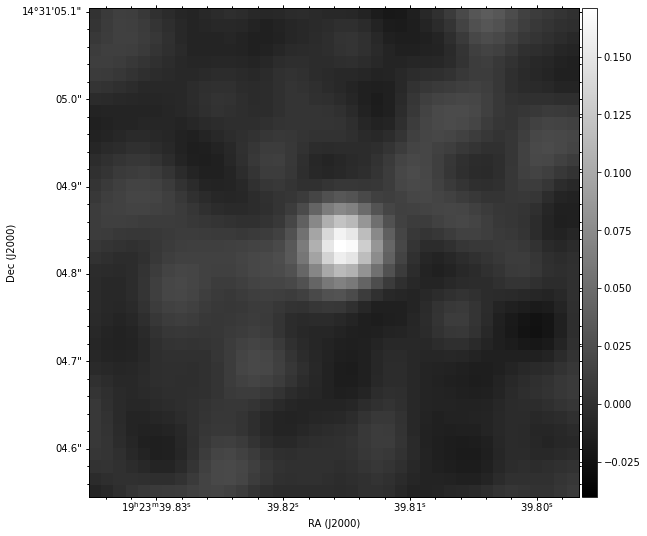

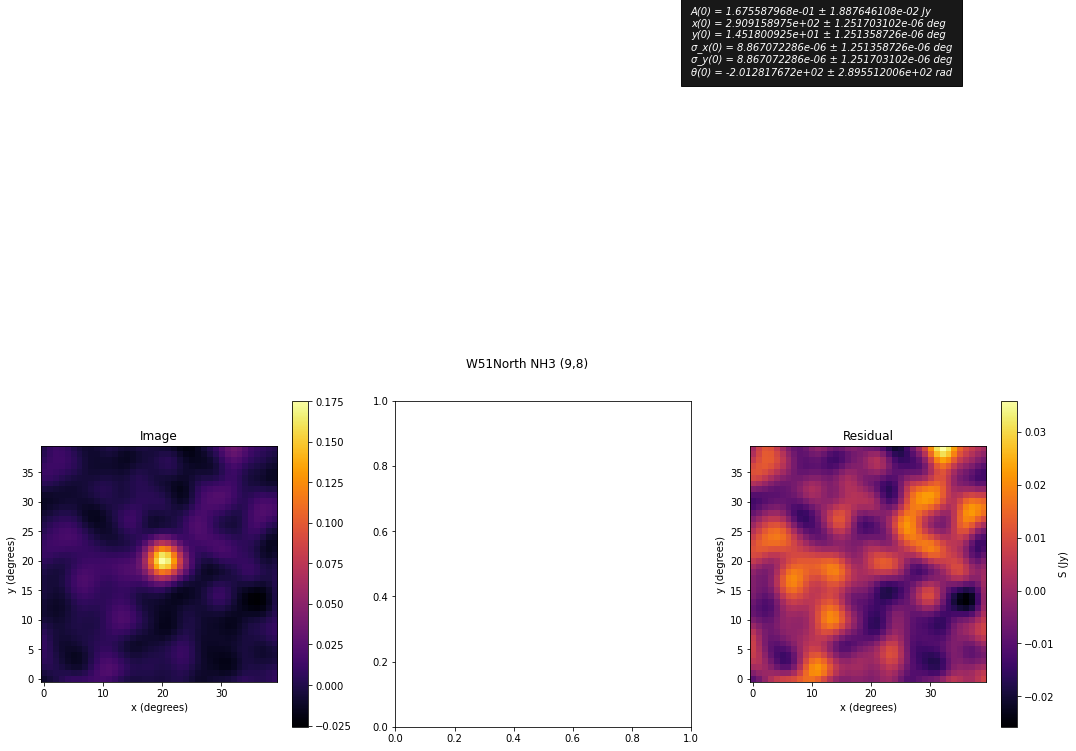

Parameter Error

1.675587968e-01 1.887646108e-02

2.909158975e+02 1.251703102e-06

1.451800925e+01 1.251358726e-06

8.867072286e-06 1.251358726e-06

8.867072286e-06 1.251703102e-06

-2.012817672e+02 2.895512006e+02



In [5]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

import pylab as pl

#Saving methods
field='W51North'
spw="8"
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/Gaussian2D_plots/'

def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit2D_V1.0.png')
            print('File saved.')
            
#Accessing Cube Data
cube = SpectralCube.read("/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_8_corrected21.image", format='casa_image')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5


# maser_channel = 579

x, y = 637, 358
size = 20

cube = cube[84,:,:]


#max_2d_cube = cube.max(axis=0)
cube_cutout = cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()
cord = cube.world[y,x]
print(cord[1])

p_init_gauss2D = models.Gaussian2D(x_mean=cord[1], y_mean=cord[0], amplitude=100 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


print("\n param_cov")

print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)




print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North NH3 (9,8)")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 2)
plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
        " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
        " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
        style='italic',
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
        horizontalalignment='left')

plt.tight_layout()
saveplotfig_gaussianfit()

plt.show()

print("Parameter" + ' ' + 'Error' +"\n")
print(amplitude + ' ' + amplitude_error +"\n")
print(x_mean + ' ' + x_mean_error +"\n")
print(y_mean + ' ' + y_mean_error +"\n")
print(x_stddev + ' ' + x_stddev_error +"\n")
print(y_stddev + ' ' + y_stddev_error +"\n")
print(theta + ' ' + theta_error +"\n")

### spw 41 point source objects

Point source at channel 52

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

import pylab as pl

import numpy as np


#Saving methods
field='W51North'
spw="41"
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/Gaussian2D_plots/'

def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit2D_V1.0.png')
            print('File saved.')
            
#Accessing Cube Data
cube = SpectralCube.read("/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_41_corrected2.image", format='casa_image')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5


# maser_channel = 579

x, y = 407, 413
size = 20

cube = cube[52,:,:]


#max_2d_cube = cube.max(axis=0)
cube_cutout = cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()
cord = cube.world[y,x]
print(cord[1])

p_init_gauss2D = models.Gaussian2D(x_mean=cord[1], y_mean=cord[0], amplitude=100 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


print("\n param_cov")

print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)




print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North SPW41 Point Source Object Channel 52")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 2)
plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
        " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
        " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
        style='italic',
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
        horizontalalignment='left')

plt.tight_layout()
saveplotfig_gaussianfit()

plt.show()

print("Parameter" + ' ' + 'Error' +"\n")
print(amplitude + ' ' + amplitude_error +"\n")
print(x_mean + ' ' + x_mean_error +"\n")
print(y_mean + ' ' + y_mean_error +"\n")
print(x_stddev + ' ' + x_stddev_error +"\n")
print(y_stddev + ' ' + y_stddev_error +"\n")
print(theta + ' ' + theta_error +"\n")



216145.38338882625 K
<bound method DaskSpectralCubeMixin.max of DaskVaryingResolutionSpectralCube with shape=(200, 800, 800) and unit=Jy / beam and chunk size (10, 50, 50):
 n_x:    800  type_x: RA---SIN  unit_x: deg    range:   290.915247 deg:  290.918457 deg
 n_y:    800  type_y: DEC--SIN  unit_y: deg    range:    14.516617 deg:   14.519724 deg
 n_s:    200  type_s: FREQ      unit_s: Hz     range: 21065605370.371 Hz:21068714616.601 Hz> Cube Max)
Jy / beam Unit Flux


INFO: Auto-setting vmin to -2.185e-02 [aplpy.core]
INFO: Auto-setting vmax to  8.444e-02 [aplpy.core]
290.91682187809823 deg
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude       x_mean       ...   y_stddev        theta       
    Jy / beam        deg         ...     deg                       
    --------- ------------------ ... ----------- ------------------
        100.0 290.91682187809823 ... 1.11111e-05 1.5707963267948966 Printed models.Gaussian2D

 param_cov
{'nfev': 4, 'fvec': array([-0.00737602, -0.00435389, -0.00223515, ...,  0.00022386,
        0.00235408,  0.0031809 ]), 'fjac': array([[-3.72924965e+04,  3.65583721e-31,  4.34353191e-30, ...,
         3.45154741e-28,  2.83840659e-29,  2.00453876e-30],
       [ 1.26810458e-03,  3.03665378e+04,  6.14121819e-31, ...,
        -5.17105519e-29, -4.29663700e-30, -3.06613844e-31],
       [-9.09369227e+03, -1.52616286e-05, -2.57208459e+04, ...,
         1.52085285e-28,  1.52051439e-29,  

/scratch/local/5169767/ipykernel_84257/375319038.py:143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, 2)


In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

import pylab as pl

#Saving methods
field='W51North'
spw="41_2"
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/Gaussian2D_plots/'

def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit2D_V1.0.png')
            print('File saved.')
            
#Accessing Cube Data
cube = SpectralCube.read("/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_41_corrected2.image", format='casa_image')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5


# maser_channel = 579

x, y = 365, 397
size = 20

cube = cube[55,:,:]


#max_2d_cube = cube.max(axis=0)
cube_cutout = cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()
cord = cube.world[y,x]
print(cord[1])

p_init_gauss2D = models.Gaussian2D(x_mean=cord[1], y_mean=cord[0], amplitude=100 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


print("\n param_cov")

print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)




print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North SPW41 Point Source Object Channel 55")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 2)
plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
        " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
        " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
        style='italic',
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
        horizontalalignment='left')

plt.tight_layout()
saveplotfig_gaussianfit()

plt.show()

print("Parameter" + ' ' + 'Error' +"\n")
print(amplitude + ' ' + amplitude_error +"\n")
print(x_mean + ' ' + x_mean_error +"\n")
print(y_mean + ' ' + y_mean_error +"\n")
print(x_stddev + ' ' + x_stddev_error +"\n")
print(y_stddev + ' ' + y_stddev_error +"\n")
print(theta + ' ' + theta_error +"\n")

<bound method DaskSpectralCubeMixin.max of DaskVaryingResolutionSpectralCube with shape=(200, 800, 800) and unit=Jy / beam and chunk size (10, 50, 50):
 n_x:    800  type_x: RA---SIN  unit_x: deg    range:   290.915247 deg:  290.918457 deg
 n_y:    800  type_y: DEC--SIN  unit_y: deg    range:    14.516617 deg:   14.519724 deg
 n_s:    200  type_s: FREQ      unit_s: Hz     range: 21065605370.371 Hz:21068714616.601 Hz> Cube Max)
Jy / beam Unit Flux
INFO: Auto-setting vmin to -6.928e-02 [aplpy.core]
INFO: Auto-setting vmax to  4.092e-01 [aplpy.core]
290.9170749595121 deg
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude       x_mean      ...   y_stddev        theta       
    Jy / beam        deg        ...     deg                       
    --------- ----------------- ... ----------- ------------------
        100.0 290.9170749595121 ... 1.11111e-05 1.5707963267948966 Printed models.Gaussian2D

 param_cov
{'nfev': 3, 'fvec': array([-0.001572

Save the gaussian fit (yes or no)? no


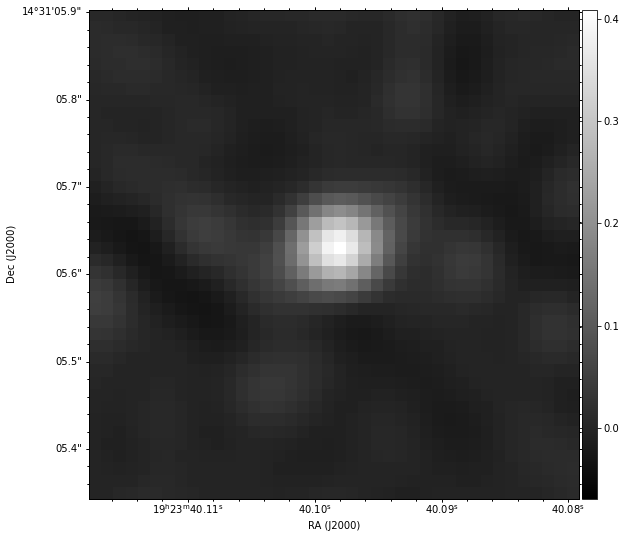

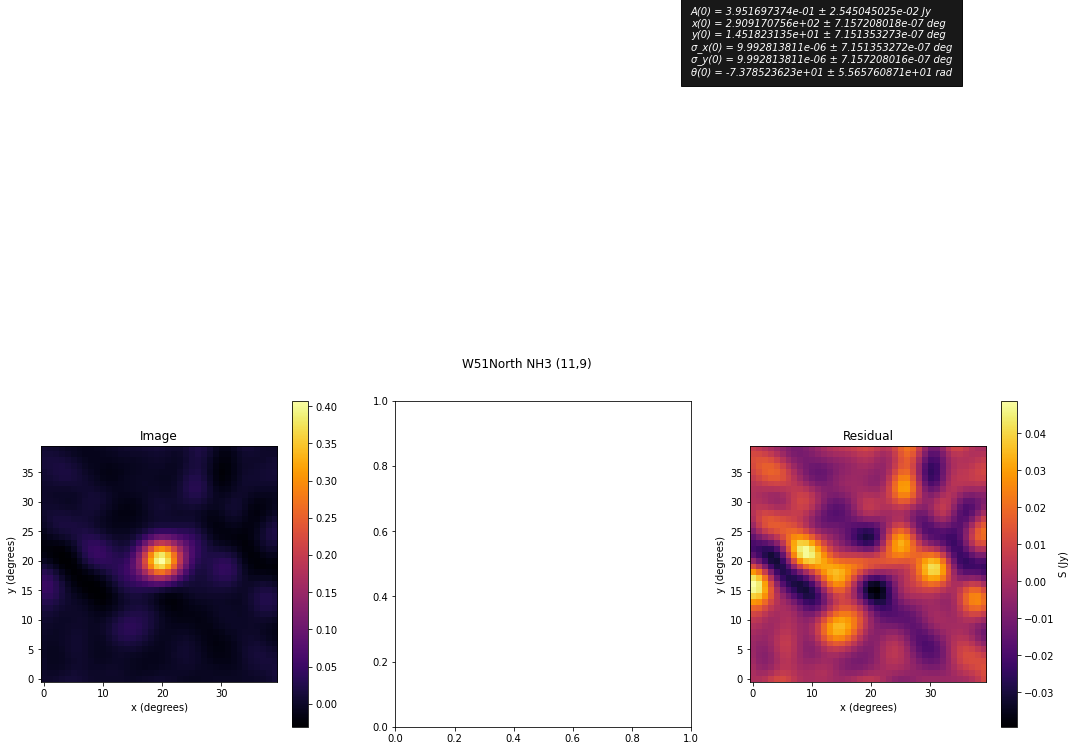

Parameter Error

3.951697374e-01 2.545045025e-02

2.909170756e+02 7.157208018e-07

1.451823135e+01 7.151353273e-07

9.992813811e-06 7.151353272e-07

9.992813811e-06 7.157208016e-07

-7.378523623e+01 5.565760871e+01



In [4]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u

from astropy.visualization import quantity_support

import pylab as pl

#Saving methods
field='W51North'
spw="41-3"
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/Gaussian2D_plots/'

def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_GaussianFit2D_V1.0.png')
            print('File saved.')
            
#Accessing Cube Data
cube = SpectralCube.read("/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_41_corrected2.image", format='casa_image')
print(cube.max,"Cube Max)")
print(cube.unit,"Unit Flux")
cube.beam_threshold = 0.5


# maser_channel = 579

x, y = 344, 415
size = 20

cube = cube[114,:,:]


#max_2d_cube = cube.max(axis=0)
cube_cutout = cube[y - size:y + size, x - size:x + size]
cube_cutout.quicklook()
cord = cube.world[y,x]
print(cord[1])

p_init_gauss2D = models.Gaussian2D(x_mean=cord[1], y_mean=cord[0], amplitude=100 * (u.Jy/u.beam),
                                   x_stddev=1.11111e-5 * u.degree, y_stddev=1.11111e-5 * u.degree, theta=(np.pi/2))

print(p_init_gauss2D,"Printed models.Gaussian2D")

yy, xx = cube_cutout.spatial_coordinate_map

fit_p = fitting.LevMarLSQFitter()


cube_cutout_quant = cube_cutout
cube_cutout_quant[np.isnan(cube_cutout_quant)] = 0.0

#p_init_gauss2D.theta.fixed = True

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)
    
# p_gauss2D_avg = (p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0])
# p_gauss2D.x_stddev[0], p_gauss2D.y_stddev[0] = p_gauss2D_avg

fitted_x_stddev = p_gauss2D.x_stddev
fitted_y_stddev = p_gauss2D.y_stddev

p_gauss2D_avg = (fitted_x_stddev + fitted_y_stddev)/2
p_gauss2D.x_stddev = p_gauss2D_avg
p_gauss2D.y_stddev = p_gauss2D_avg


print("\n param_cov")

print(fit_p.fit_info)

cov = np.diag(fit_p.fit_info['param_cov'])
errors = np.sqrt(cov)

print("The errors are:\n", errors)

amplitude_error=np.format_float_scientific(errors[0],precision=9)
x_mean_error=np.format_float_scientific(errors[1],precision=9)
y_mean_error=np.format_float_scientific(errors[2],precision=9)
x_stddev_error=np.format_float_scientific(errors[3],precision=9)
y_stddev_error=np.format_float_scientific(errors[4],precision=9)
theta_error=np.format_float_scientific(errors[5],precision=9)

amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)




print(p_gauss2D.amplitude)
print(p_gauss2D.x_mean)
print(p_gauss2D.y_mean)
print(p_gauss2D.x_stddev)
print(p_gauss2D.y_stddev)

print(p_gauss2D)
              
plt.figure(figsize=(18, 6))
plt.suptitle("W51North NH3 (11,9)")
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")
plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar(label='S (Jy)')
plt.xlabel("x (degrees)")
plt.ylabel("y (degrees)")

plt.subplot(1, 3, 2)
plt.text(1, 2, "A(0) = "+str(amplitude)+" ± "+str(amplitude_error)+" Jy\n"+"x(0) = "+str(x_mean)+" ± "+str(x_mean_error)+
        " deg\n"+"y(0) = "+str(y_mean)+" ± "+str(y_mean_error)+ " deg\n" + "σ_x(0) = "+str(x_stddev)+" ± "+str(x_stddev_error)+
        " deg\n"+"σ_y(0) = "+str(y_stddev)+" ± "+str(y_stddev_error)+" deg\n" +"θ(0) = "+str(theta)+" ± "+str(theta_error)+" rad",
        style='italic',
        bbox={'facecolor': 'black', 'alpha': 0.9, 'pad': 10}, color="white",
        horizontalalignment='left')

plt.tight_layout()
saveplotfig_gaussianfit()

plt.show()

print("Parameter" + ' ' + 'Error' +"\n")
print(amplitude + ' ' + amplitude_error +"\n")
print(x_mean + ' ' + x_mean_error +"\n")
print(y_mean + ' ' + y_mean_error +"\n")
print(x_stddev + ' ' + x_stddev_error +"\n")
print(y_stddev + ' ' + y_stddev_error +"\n")
print(theta + ' ' + theta_error +"\n")

Cube is a Stokes cube, returning spectral cube for I component


Save the gaussian fit (yes or no)? yes


File saved.


Save the residual (yes or no)? yes


File saved.


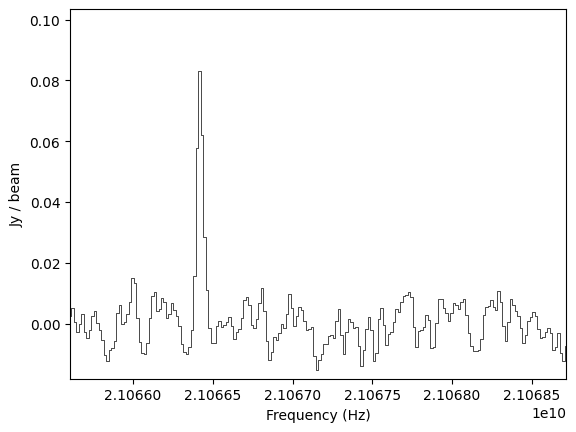

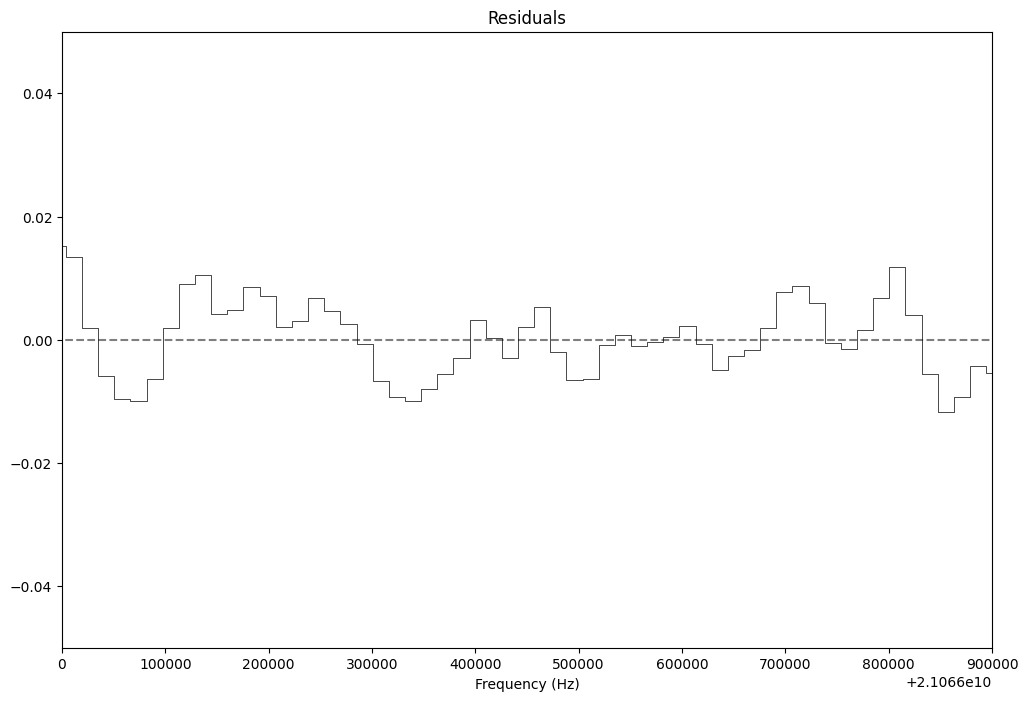

In [9]:
import pyspeckit
from spectral_cube import SpectralCube

#Import data
cube = SpectralCube.read('/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_41_corrected2.image', format='casa_image')

import pylab as pl
pl.style.use('default')

#Pixel location (x,y)
x, y = 407, 413

sp = pyspeckit.Spectrum(xarr=cube.spectral_axis, data=cube[:, y, x])
sp.plotter(color='black')

#Saving methods
field='W51North'
spw="41"
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/'

#Save gaussianfit
def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            sp.plotter.savefig(directory1+field+'_spw_'+str(spw)+'_corrected_1_GaussianFit1D_V1.3.png')
            print('File saved.')
        
#Save residual        
def saveplotfig_residual():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the residual (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_corrected_1_GaussianFit1D_residual_V1.3.png')
            print('File saved.')
            
from astropy import units as u

#Plot the gassiuan fits in to each peak in the spectra
fig = pl.figure(figsize=(12,8))
sp.plotter(color='black', xmin=21.0660*u.GHz, xmax=21.0669*u.GHz, figure=fig)

sp.specfit(guesses=[0.1, 21.06645e9, 0.00001e9], linewidth=1.5)
sp.specfit(guesses=[0.1, 21.06645e9, 0.00001e9], linewidth=1.5)

# sp.specfit.plot_fit(lw=1.0, composite_lw=1.8, show_components=True)
saveplotfig_gaussianfit()

#Plot the residuals of the gassiuan fits
sp.specfit.plotresiduals(color='black', zeroline=True)
pl.ylim(-0.05, 0.05)
saveplotfig_residual()

Cube is a Stokes cube, returning spectral cube for I component


Save the residual (yes or no)? yes


File saved.


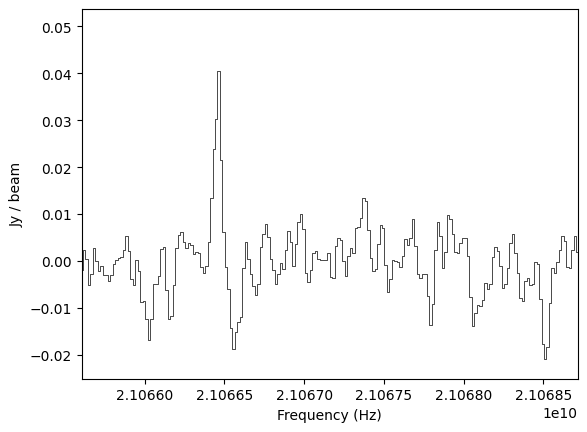

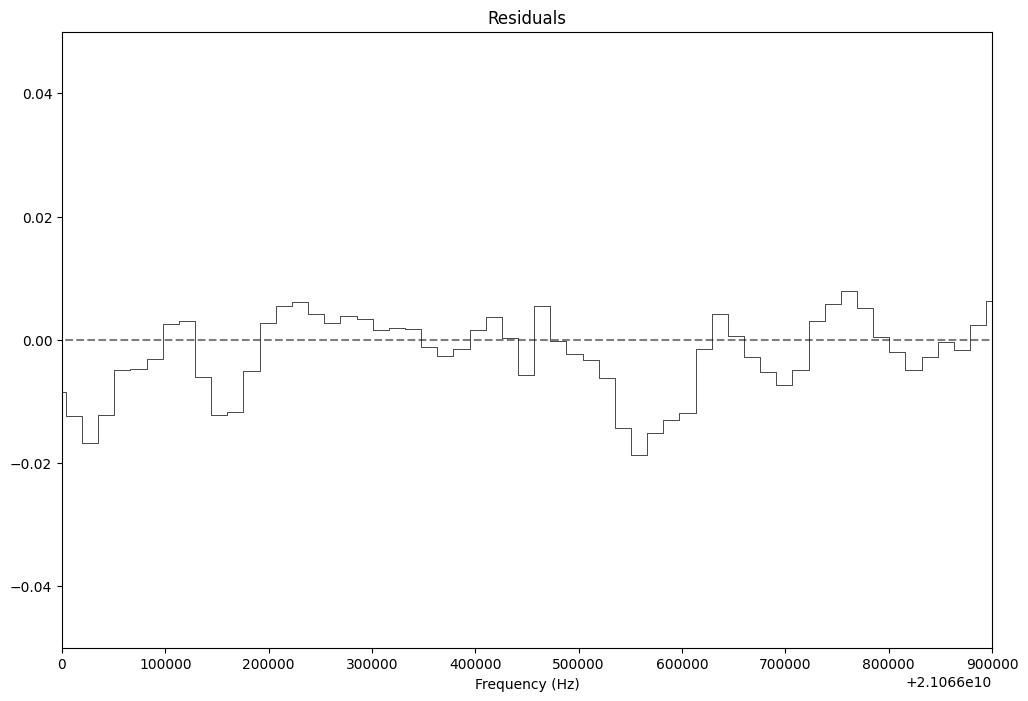

In [13]:
import pyspeckit
from spectral_cube import SpectralCube

#Import data
cube = SpectralCube.read('/orange/adamginsburg/w51/vla/19A-254/derod/W51North_spw_41_corrected2.image', format='casa_image')

import pylab as pl
pl.style.use('default')

#Pixel location (x,y)
x, y = 365, 397

sp = pyspeckit.Spectrum(xarr=cube.spectral_axis, data=cube[:, y, x])
sp.plotter(color='black')

#Saving methods
field='W51North'
spw=41
directory1 = '/orange/adamginsburg/w51/vla/19A-254/derod/W51-Masers-and-Starforming-Regions/gaussianplots/'

#Save gaussianfit
def saveplotfig_gaussianfit():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the gaussian fit (yes or no)?") 
        if answer == "yes": 
            sp.plotter.savefig(directory1+field+'_spw_'+str(spw)+'_corrected_2_GaussianFit1D_V1.3.png')
            print('File saved.')
        
#Save residual        
def saveplotfig_residual():
    answer = None 
    while answer not in ("yes", "no"): 
        answer = input("Save the residual (yes or no)?") 
        if answer == "yes": 
            pl.savefig(directory1+field+'_spw_'+str(spw)+'_corrected_2_GaussianFit1D_residual_V1.3.png')
            print('File saved.')
            
from astropy import units as u

#Plot the gassiuan fits in to each peak in the spectra
fig = pl.figure(figsize=(12,8))
sp.plotter(color='black', xmin=21.0660*u.GHz, xmax=21.0669*u.GHz, figure=fig)

sp.specfit(guesses=[0.1, 21.06645e9, 0.00001e9], linewidth=1.5)
sp.specfit(guesses=[0.1, 21.06645e9, 0.00001e9], linewidth=1.5)

# # sp.specfit.plot_fit(lw=1.0, composite_lw=1.8, show_components=True)
# saveplotfig_gaussianfit()

#Plot the residuals of the gassiuan fits
sp.specfit.plotresiduals(color='black', zeroline=True)
pl.ylim(-0.05, 0.05)
saveplotfig_residual()


